# Event Studies of Key Developments News

- event study: CAR, BHAR, post-announcement drift (Kolari 2010 and others)
- cross-sectional correlation: cross-correlation, convolution, FFT
- multiple testing: Holm FWER, Benjamin-Hochberg FDR, Bonferroni p-values

Copyright 2023, Terence Lim

MIT License

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
from finds.database import SQL
from finds.busday import BusDay
from finds.structured import PSTAT, CRSP, Benchmarks, Stocks
from finds.backtesting import EventStudy
from finds.display import show
from conf import CRSP_DATE, VERBOSE, credentials, paths
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)      # show DataFrame by just returning it
%matplotlib inline

LAST_DATE = CRSP_DATE
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
keydev = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=None, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
eventstudy = EventStudy(user, bench=bench, stocks=crsp, max_date=LAST_DATE)
imgdir = paths['images'] / 'events'

# event window parameters
end = 20220228
beg = 19890101  # 20020101
minobs = 250
left, right, post = -1, 1, 21

# sorted list of all eventids and roleids, provided in keydev class
events = sorted(keydev._event.keys())
roles = sorted(keydev._role.keys())

# str formatter to pretty print descriptions, provided in keydev class
eventformat = lambda e, r: "{event} ({eventid}) {role} [{roleid}]"\
    .format(event=keydev._event[e],
            eventid=e,
            role=keydev._role[r],
            roleid=r) 

Last FamaFrench Date 2022-11-30 00:00:00


### Helper to merge events and crsp, and screen stock universe

In [3]:
# to lookup prevailing exchange and share codes by permno and date
shrcd = crsp.build_lookup('permno', 'shrcd')
exchcd = crsp.build_lookup('permno', 'exchcd')
def event_pipeline(eventstudy: EventStudy, stocks: Stocks, beg: int, end: int,
                   eventid: int, roleid: int, left: int, right: int, post: int,
                   mincap: float = 300000.) -> DataFrame:
    """helper to merge keydev events and crsp, and screen stock universe"""

    # Retrieve announcement dates for this event
    df = keydev.get_linked(
        dataset='keydev',
        date_field='announcedate',
        fields=['keydevid',
                'keydeveventtypeid',
                'keydevtoobjectroletypeid'],
        where=(f"announcedate >= {beg} "
               f"  and announcedate <= {end}"
               f"  and keydeveventtypeid = {eventid} "
               f"  and keydevtoobjectroletypeid = {roleid}"))\
               .drop_duplicates(['permno', 'announcedate'])\
               .set_index(['permno', 'announcedate'], drop=False)

    # Require in valid screen: 'cap', 'exchcd', 'shcrd'
    stk = stocks.get_many(dataset='daily',
                          permnos=df['permno'],
                          date_field='date',
                          dates=stocks.bd.offset(df['announcedate'], left-1),
                          fields=['prc', 'shrout']).fillna(0)
    df['cap'] = (stk['prc'].abs() * stk['shrout']).values
    df['exchcd'] = [exchcd(row.permno, row.date) for row in stk.itertuples()]
    df['shrcd'] = [shrcd(row.permno, row.date) for row in stk.itertuples()]
    select = (df['cap'].gt(mincap)                  # require cap > $300M
              & df['exchcd'].isin([1, 2, 3])        # primary exchange
              & df['shrcd'].isin([10, 11])).values  # domestic common stocks

    # Call eventstudy to retrieve daily abnormal returns, with named label
    rows = eventstudy(label=f"{eventid}_{roleid}",
                      df=df[select],
                      left=left,
                      right=right,
                      post=post,
                      date_field='announcedate')
    return df.loc[rows.to_records(index=False).tolist()]  # restrict df to rows

### Compute BHAR and CAR of all events

In [ ]:
restart = 0
for i, eventid in tqdm(enumerate(events)):
    if eventid <= restart:  # kludge to resume loop
        continue
    for roleid in roles:
        # retrieve all returns observations of this eventid, roleid
        df = event_pipeline(eventstudy,
                            stocks=crsp,
                            beg=beg,
                            end=end,
                            eventid=eventid,
                            roleid=roleid,
                            left=left,
                            right=right,
                            post=post)
        if df['announcedate'].nunique() < minobs:  # require min number of dates
            continue

        # compute both BHAR and CAR averages, then plot and save
        bhar = eventstudy.fit(model='sbhar')
        car = eventstudy.fit(model='scar')
        #eventstudy.write()
        eventstudy.write_summary()
        #print(eventstudy.label, eventid, roleid)
        show(DataFrame.from_dict(car | bhar, orient='index'))

        fig, axes = plt.subplots(2, 1, clear=True, figsize=(5, 5), num=1)
        eventstudy.plot(model='sbhar', ax=axes[0], title=eventstudy.label,
                        fontsize=8, vline=[right])
        eventstudy.plot(model='scar', ax=axes[1], title='',
                        fontsize=8, vline=[right])
        plt.savefig(imgdir / f"{eventid}_{roleid}.jpg")

## Show subsample plots for selected events

### Show by market cap and half-period

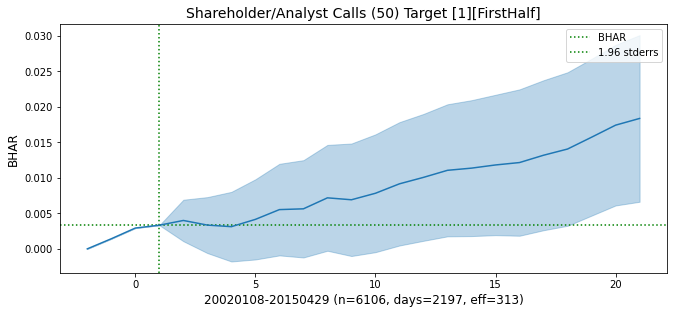

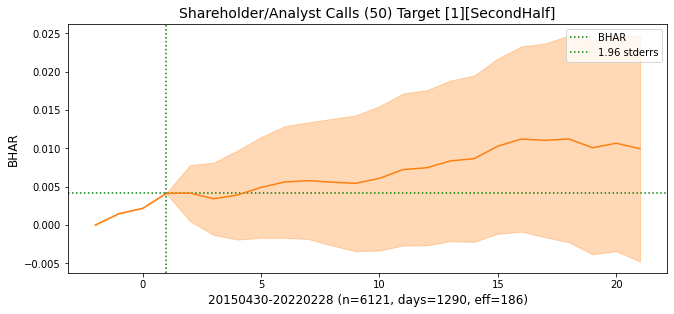

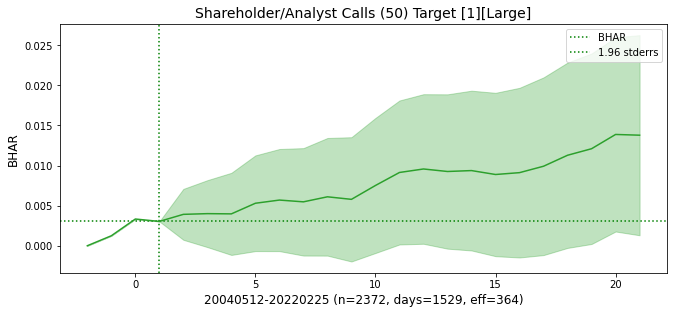

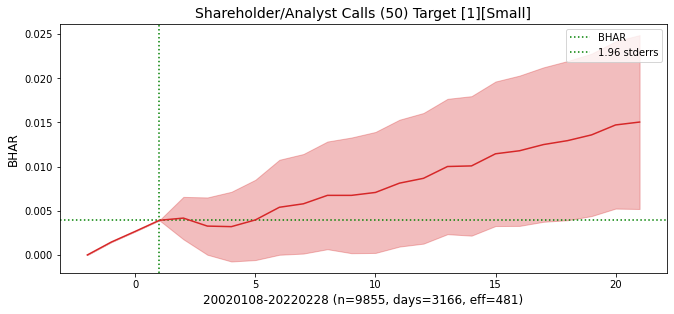

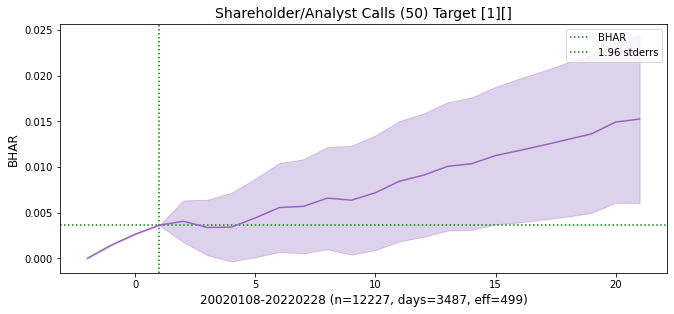

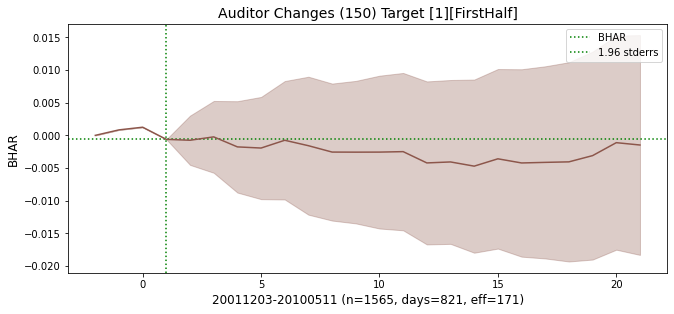

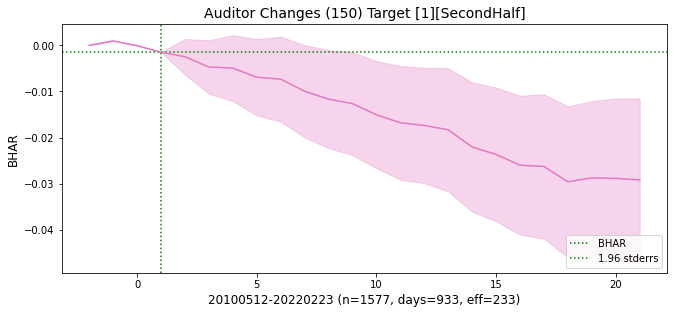

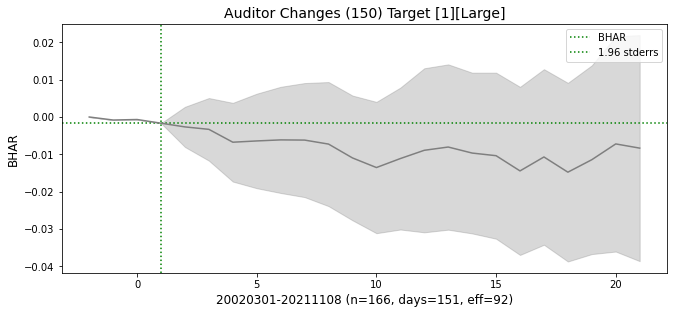

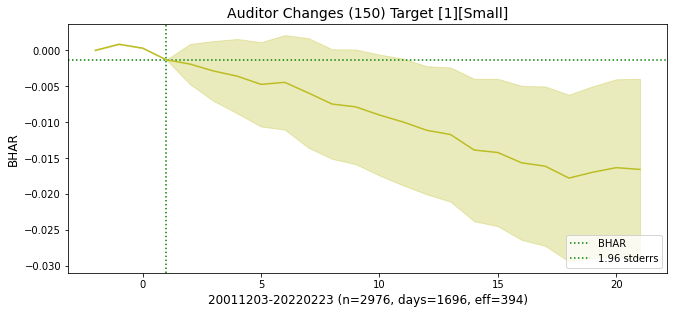

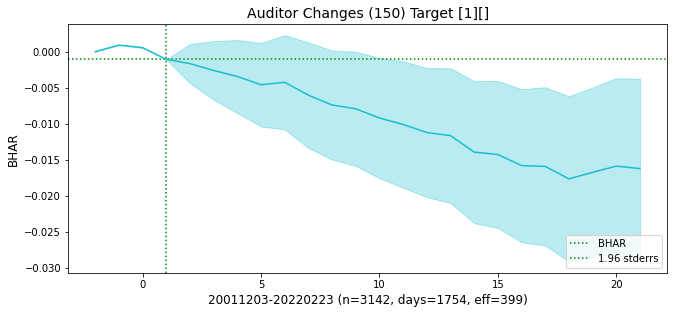

In [19]:
events_list = [[50, 1], [150, 1]]  # top drift
midcap = 20000000   # arbitrary mid market cap breakpoint
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        stocks=crsp,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].lt(halfperiod).values,
              'SecondHalf': df['announcedate'].ge(halfperiod).values,
              'Large': df['cap'].ge(midcap).values,
              'Small': df['cap'].lt(midcap).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f"[{label}]",
                        drift=True,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

### Show by market cap and half-period

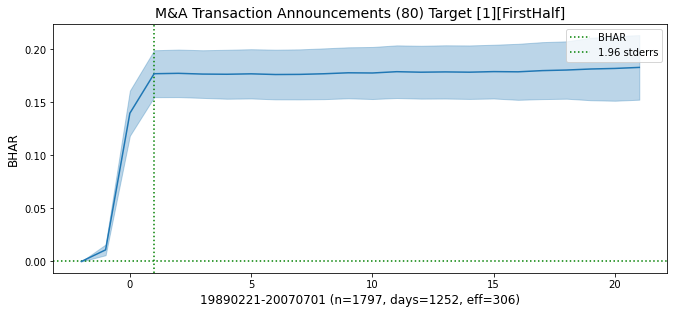

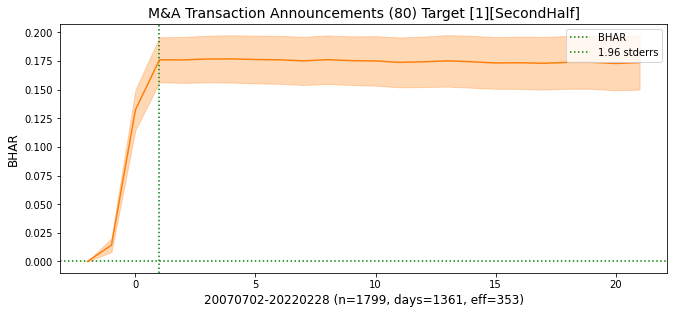

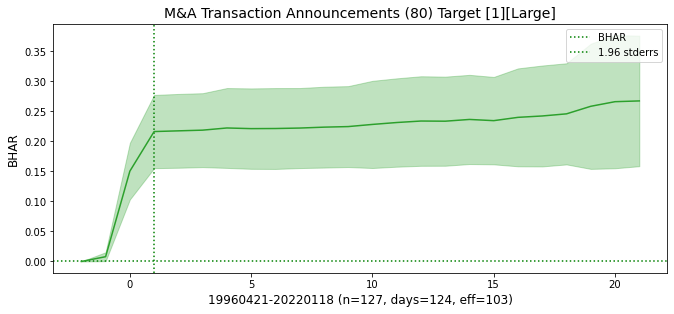

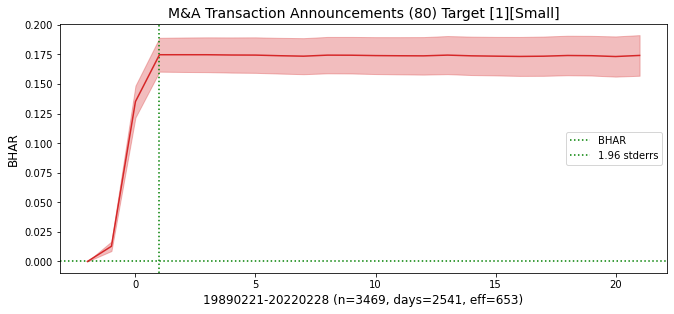

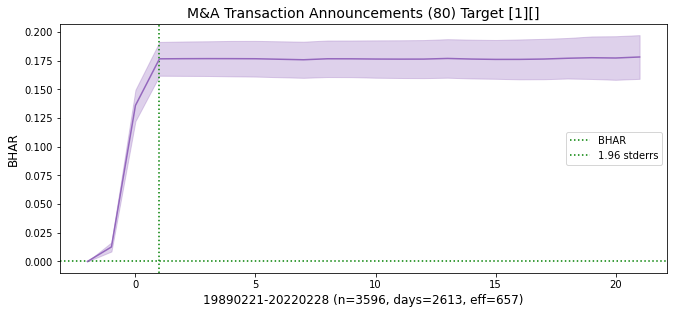

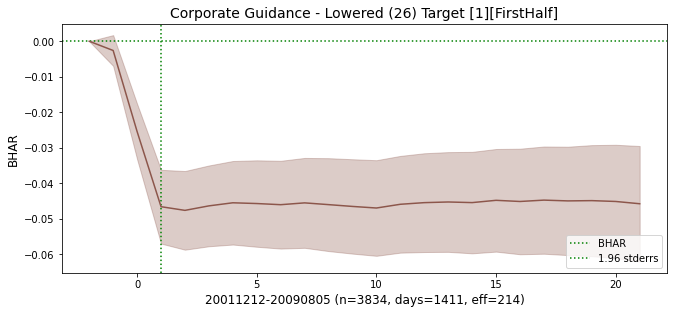

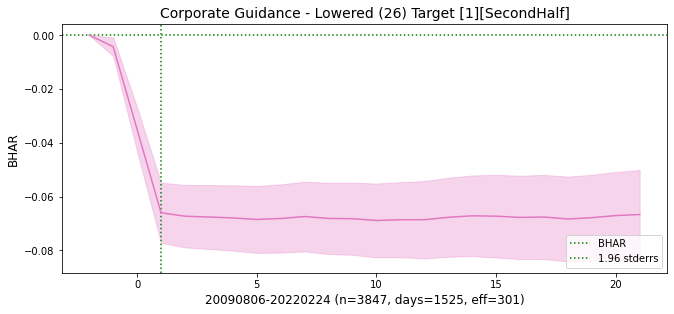

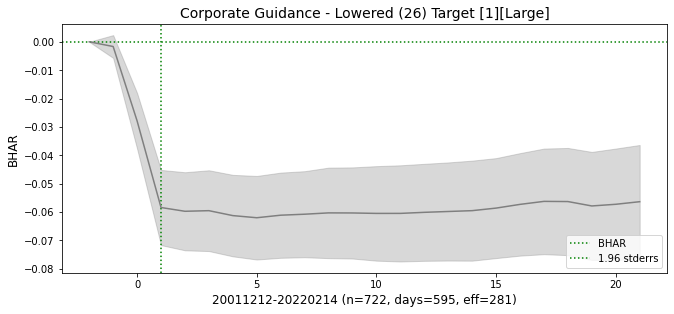

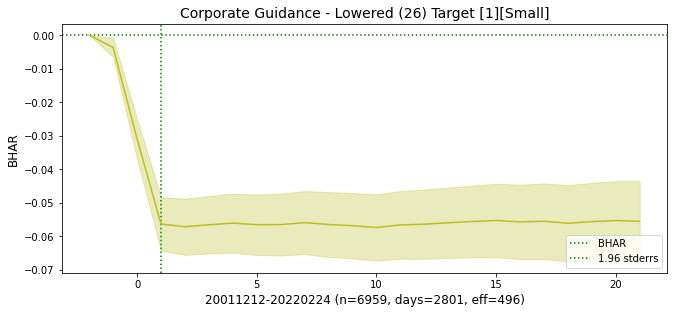

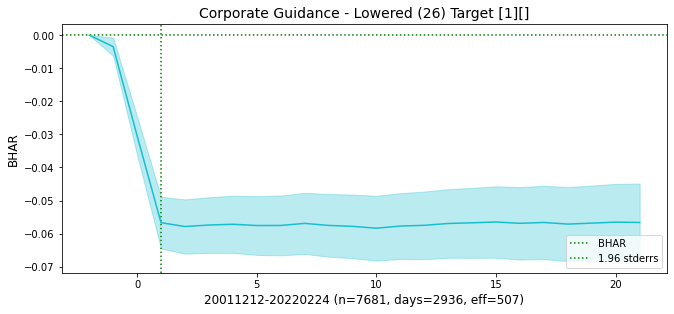

In [20]:
events_list = [[80,1], [26,1]]  # top announcement window
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        stocks=crsp,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].lt(halfperiod).values,
              'SecondHalf': df['announcedate'].ge(halfperiod).values,
              'Large': df['cap'].ge(midcap).values,
              'Small': df['cap'].lt(midcap).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f"[{label}]",
                        drift=False,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

## Summarize BHAR's of all events

In [21]:
# sorted by 3-day event window abnormal returns
df = eventstudy.read_summary(model='sbhar')\
               .set_index('label')\
               .drop(columns=['rho', 'tau', 'created'])\
               .sort_values('window', ascending=False)

# convert (eventid, roleid) to multiindex
df = df[df['days'] > 500].sort_values('post_t')
multiIndex = DataFrame(df.index.str.split('_').to_list()).astype(int)
df.index = pd.MultiIndex.from_frame(multiIndex, names=['eventid', 'roleid'])

# show summary
df['event'] = keydev._event[df.index.get_level_values(0)].values
df['role'] = keydev._role[df.index.get_level_values(1)].values
show(df.set_index(['event', 'role']).drop(columns=['model']),
     caption=["Post-Announcement Drift", None], **SHOW)

,,beg,end,rows,days,effective,window,window_t,post,post_t
Post-Announcement Drift,,,,,,,,,,
Auditor Changes,Target,20011203,20220223,3142,1754,399.0,-0.0011,-0.3943,-0.0151,-2.3804
Index Constituent Adds,Target,19890911,20220225,19227,2034,559.0,-0.0022,-0.8564,-0.0109,-2.0668
Executive Changes - CEO,Target,20000515,20220228,7965,3881,600.0,-0.0052,-1.8109,-0.0076,-1.5904
Private Placements,Target,19890102,20220228,3402,2436,592.0,0.0108,2.4249,-0.0119,-1.5229
Shelf Registration Filings,Target,19900911,20220228,30882,6291,800.0,-0.0023,-1.4453,-0.0050,-1.4138
...,...,...,...,...,...,...,...,...,...,...
Special Dividend Announced,Target,20020429,20220225,1660,1214,346.0,0.0203,6.4112,0.0091,1.6419
Buyback Transaction Announcements,Target,19930928,20220228,12790,3996,590.0,0.0091,4.1839,0.0062,1.7540
Annual General Meeting,Target,19960313,20220228,35308,4087,533.0,0.0017,1.0921,0.0078,2.0382


## Multiple Testing                                                               


### Show actual two-sided p-values vs expected (with continuity correction) 

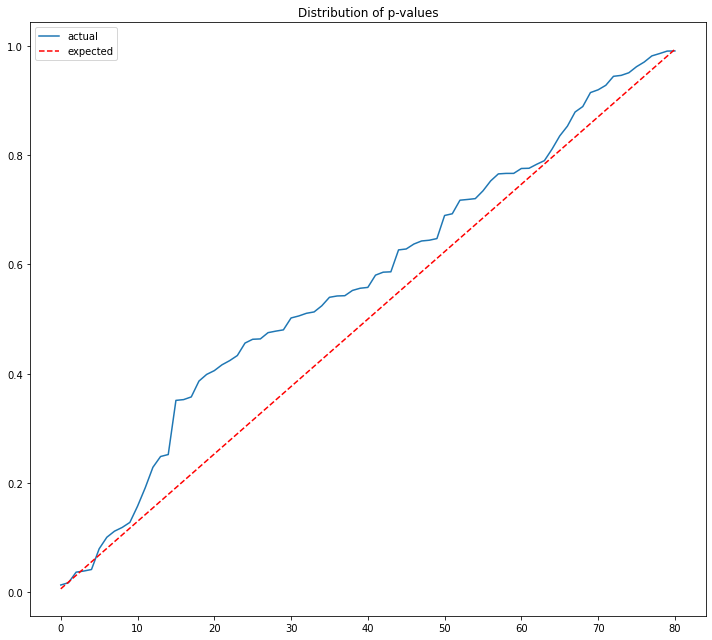

In [22]:
pvals = list(norm.cdf(-df['post_t'].abs()) * 2)
argmin = np.argmin(pvals)
header = df.iloc[argmin][['event', 'role', 'days', 'effective', 'post_t']]\
           .to_dict()
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 9))
ax.plot(sorted(pvals))
ax.plot([0, len(pvals)-1], [0.5/len(pvals), (len(pvals)-0.5)/len(pvals)], 'r--')
ax.set_title('Distribution of p-values')
ax.legend(['actual', 'expected'])
plt.tight_layout()
plt.savefig(imgdir / 'pvals.jpg')

### Bonferroni, Holm and Benjamin-Hochberg methods 

In [23]:
alpha = 0.05

results = {}
for method in ['bonferroni', 'holm', 'fdr_bh']:
    tests =  multipletests(pvals, alpha=alpha, method=method)
    results[method] = header | {f'pval(alpha={alpha})': pvals[argmin],
                                'adj-pval': tests[1][argmin]}
show(DataFrame.from_dict(results, orient='index'),
     caption="Multiple Testing methods", **SHOW)

,event,role,days,effective,post_t,pval(alpha=0.05),adj-pval
Multiple Testing methods,,,,,,,
bonferroni,Shareholder/Analyst Calls,Target,3487,499.0,2.4787,0.0132,1.0000
holm,Shareholder/Analyst Calls,Target,3487,499.0,2.4787,0.0132,1.0000
fdr_bh,Shareholder/Analyst Calls,Target,3487,499.0,2.4787,0.0132,0.6728
